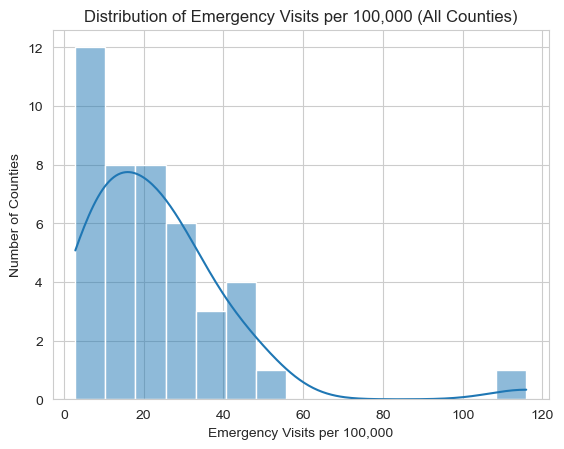

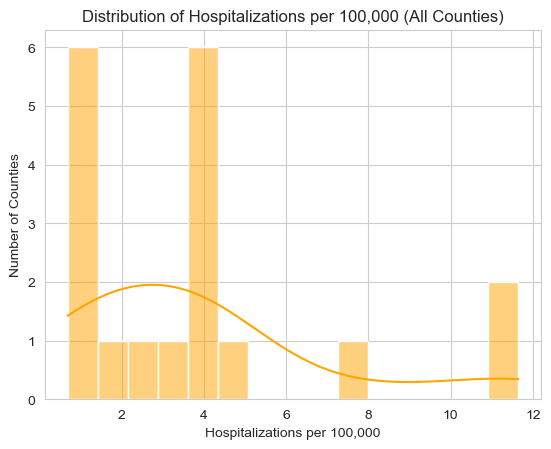

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel('County_Statistics_with_Temp.xlsx')

# Emergency Visits
sns.histplot(df['Emergency Visits / 100000'], bins=15, kde=True)
plt.title('Distribution of Emergency Visits per 100,000 (All Counties)')
plt.xlabel('Emergency Visits per 100,000')
plt.ylabel('Number of Counties')
plt.show()

# Hospitalizations
sns.histplot(df['Hospitalizations / 100000'], bins=15, kde=True, color='orange')
plt.title('Distribution of Hospitalizations per 100,000 (All Counties)')
plt.xlabel('Hospitalizations per 100,000')
plt.ylabel('Number of Counties')
plt.show()
#Notes: A few counties have high ER visit and that corresponds to high heat counties like Imperial County
# Same with hospitalization

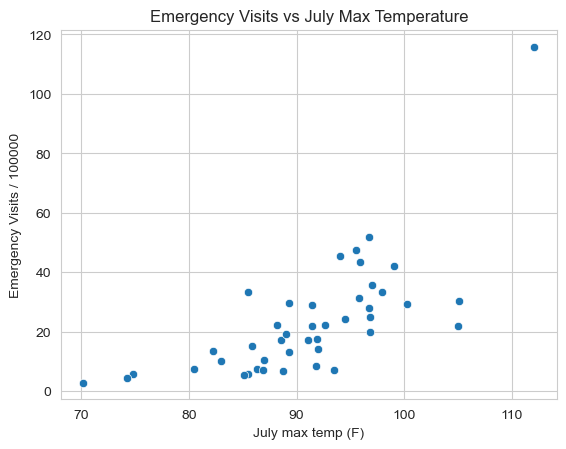

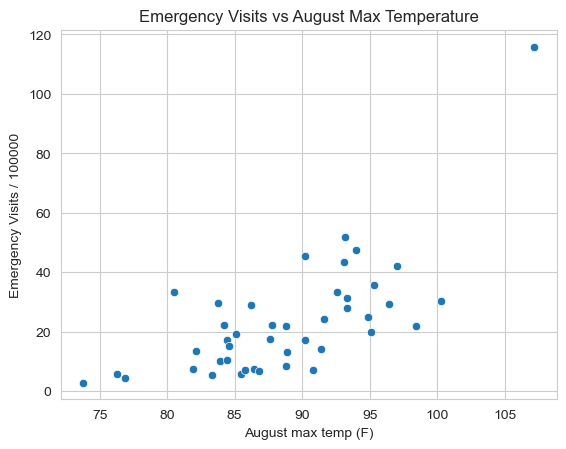

In [8]:
sns.scatterplot(
    data=df,
    x='July max temp (F)',
    y='Emergency Visits / 100000'
)
plt.title('Emergency Visits vs July Max Temperature')
plt.show()
# Perfect! More hot means more ER visit. Are the dates same? If yes, then this is a trend.

sns.scatterplot(
    data=df,
    x='August max temp (F)',
    y='Emergency Visits / 100000'
)
plt.title('Emergency Visits vs August Max Temperature')
plt.show()
#same trend for August

In [9]:
df[['Emergency Visits / 100000', 'August max temp (F)']].corr()


,Emergency Visits / 100000,August max temp (F)
Emergency Visits / 100000,1.000000,0.687191
August max temp (F),0.687191,1.000000


In [10]:
df[['Emergency Visits / 100000', 'July max temp (F)']].corr()
#Looking at the correlations, it look like we get up to 0.7 correlation with the July temperature data
#Looking at the graphs, I am not sure if a linear fitting is best. Lets try other types of fitting 

#I am considering a piecewise relationship, since there might be a threshold temperature
#Below threshold temperature, no unusual risk of heat stroke 
# https://www.dir.ca.gov/dosh/heatillnessinvestigations-2006.pdf 
# https://www.lni.wa.gov/safety-health/safety-training-materials/workshops-events/beheatsmart#questions-and-answers
# Both of these suggest to set the threshold to 80 F 

,Emergency Visits / 100000,July max temp (F)
Emergency Visits / 100000,1.000000,0.703606
July max temp (F),0.703606,1.000000


In [11]:
df.sample(4)

,County,Emergency Visits / 100000,Hospitalizations / 100000,Energy Burden % of Income,Imperviousness,Park within 1/2 Mile,Hospital Beds / 10000,Housing Built before 1980,Housing Insecurity,Lack of Reliable Transportation,% w/o Internet,Utility Services Threat,July max temp (F),August max temp (F),July CDD,August CDD
43,Santa Cruz,7.31,NaN,1.6%,4.8%,85.8%,13.76,65.62%,12.4%,8.1%,4.9%,6.5%,80.5,81.9,67,126
29,Orange,5.90,0.68,1.3%,34.7%,91.3%,18.79,60.12%,11.1%,7.3%,4.6%,5.3%,85.5,85.5,300,305
30,Placer,19.06,3.71,2.2%,3.5%,74.1%,18.44,30.33%,8.9%,5.9%,5.0%,4.8%,89.0,85.1,273,198
10,Glenn,47.49,NaN,3.6%,1.0%,37.8%,16.27,58.14%,18.3%,12.1%,12.8%,9.5%,95.5,94.0,467,443


In [12]:
df_Emergengy = df.dropna(subset=['Emergency Visits / 100000'])
df_Emergengy = df_Emergengy.drop('Hospitalizations / 100000', axis=1)



In [ ]:
x_july = df_Emergengy['July max temp (F)']
y = df_Emergengy['Emergency Visits / 100000']
# As numpy arrays
x_july_np = x_july.to_numpy()
y_np = y.to_numpy()
# Or as Python lists
x_july_list = x_july.tolist()
y_list = y.tolist()

x_august = df_Emergengy['August max temp (F)']
x_august_np = x_august.to_numpy()
# Or as Python lists
x_august_list = x_august.tolist()




Optimization success: True
Message: `ftol` termination condition is satisfied.
Fitted parameters (continuity enforced at x=80.0):
  Linear branch: p0 (intercept) = 0.53608, p1 (slope) = 1.11063e-14
  Nonlinear branch: m = 0.1, a = 1.56568, b (derived) = -94.8818
RMSE = 12.9320, R^2 = 0.5477


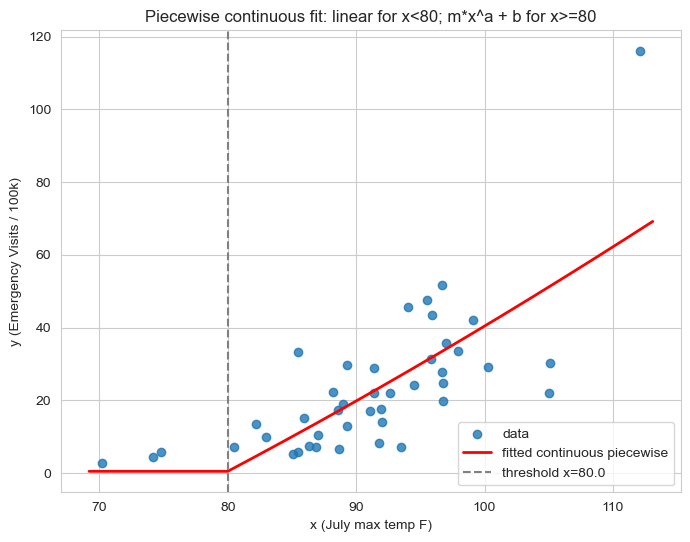

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Threshold
x_thresh = 80.0
# Piecewise model
def piecewise_continuous(params, x):
    p0, p1, m, a = params
    b = p0 + p1 * x_thresh - m * (x_thresh ** a)
    y_pred = np.empty_like(x, dtype=float)
    low_mask = x < x_thresh
    high_mask = ~low_mask
    y_pred[low_mask] = p0 + p1 * x[low_mask]
    # high branch uses computed b
    y_pred[high_mask] = m * (x[high_mask] ** a) + b
    return y_pred

# Residuals for least_squares
def residuals(params, x, y):
    return piecewise_continuous(params, x) - y
x = np.asarray(x_july_list, dtype=float)
y = np.asarray(y_list, dtype=float)

# Initial guesses
# linear init from points with x < 80 if available
if np.any(x < x_thresh) and np.sum(x < x_thresh) >= 2:
    xi = x[x < x_thresh]; yi = y[x < x_thresh]
    slope, intercept = np.polyfit(xi, yi, 1)  # returns [slope, intercept]
    p1_init, p0_init = slope, intercept
else:
    p0_init, p1_init = 0.0, 0.1
# init for nonlinear branch
m_init = max(1e-6, np.nanmean(y) / (np.nanmean(x)**1))
a_init = 1.0
init = np.array([p0_init, p1_init, m_init, a_init], dtype=float)
# Bounds: allow a up to 5 (and down to -5 here; change lower bound if you want nonnegative only)
lower = [-1e4, 0, 1e-1, -5.0]
upper = [ 1e4,  1e3,  1e4, 5.0]   # a upper bound set to 15 as requested
# Use robust loss if outliers are present (optional: loss='soft_l1')
res = least_squares(residuals, init, args=(x, y), bounds=(lower, upper),
                    ftol=1e-9, xtol=1e-9, gtol=1e-9, max_nfev=50000)
p0, p1, m, a = res.x
b = p0 + p1 * x_thresh - m * (x_thresh ** a)
# Print fitted params and metrics
y_pred = piecewise_continuous(res.x, x)
resid = y - y_pred
rss = np.sum(resid**2)
rmse = np.sqrt(rss / len(y))
r2 = 1 - rss / np.sum((y - np.mean(y))**2)
print("Optimization success:", res.success)
print("Message:", res.message)
print(f"Fitted parameters (continuity enforced at x={x_thresh}):")
print(f"  Linear branch: p0 (intercept) = {p0:.6g}, p1 (slope) = {p1:.6g}")
print(f"  Nonlinear branch: m = {m:.6g}, a = {a:.6g}, b (derived) = {b:.6g}")
print(f"RMSE = {rmse:.4f}, R^2 = {r2:.4f}")
# Plot data and fitted piecewise function
plt.figure(figsize=(8,6))
plt.scatter(x, y, c='C0', label='data', alpha=0.8)
xs = np.linspace(x.min() - 1, x.max() + 1, 800)
ys = piecewise_continuous(res.x, xs)
plt.plot(xs, ys, color='red', lw=2, label='fitted continuous piecewise')
plt.axvline(x_thresh, color='gray', ls='--', label=f'threshold x={x_thresh}')
plt.xlabel('x (July max temp F)')
plt.ylabel('y (Emergency Visits / 100k)')
plt.legend()
plt.title('Piecewise continuous fit: linear for x<80; m*x^a + b for x>=80')
plt.show()

In [15]:
#hmm, piecewise doesn't seem to be working well. I was hoping for an exponent value higher

success: True `ftol` termination condition is satisfied.
m = 0.2, a = 1.43969, b = -110.754
RMSE = 13.3856, R^2 = 0.5140


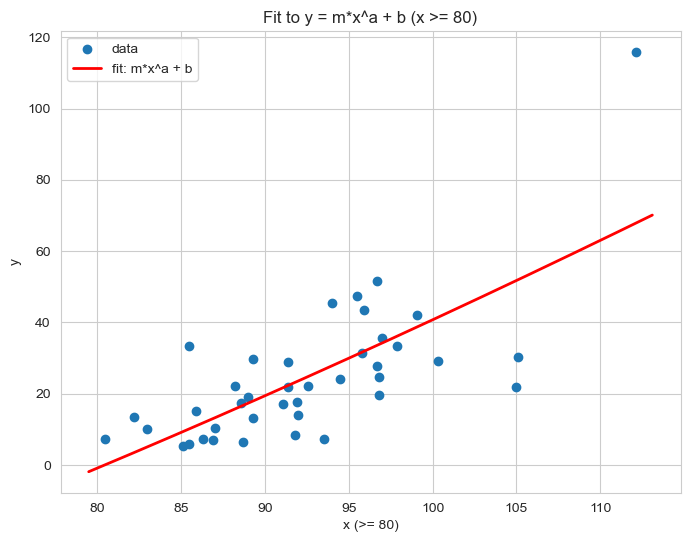

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Replace these with your arrays (lists or 1D numpy arrays)
x_all = np.asarray(x_july_list, dtype=float)
y_all = np.asarray(y_list, dtype=float)

# Select x >= threshold and drop NaNs
x_thresh = 80.0
mask = (x_all >= x_thresh) & ~np.isnan(x_all) & ~np.isnan(y_all)
x = x_all[mask]
y = y_all[mask]

if len(x) == 0:
    raise ValueError("No data points with x >= {}".format(x_thresh))

# Model: y = m * x**a + b
def model(params, x):
    m, a, b = params
    return m * (x ** a) + b

def residuals(params, x, y):
    return model(params, x) - y

# initial guesses
m_init = max(1e-6, np.nanmean(y) / (np.nanmean(x) ** 1))
a_init = 1.0
b_init = np.median(y)  # reasonable starting offset
init = np.array([m_init, a_init, b_init], dtype=float)

# bounds: allow a up to 15
lower = [ 0.2,  -5.0, -1e6]   # allow m negative if desired, a >= -5, b wide
upper = [  1e6,  5.0,  1e6]   # a upper bound 5

res = least_squares(residuals, init, args=(x, y), bounds=(lower, upper),
                    ftol=1e-9, xtol=1e-9, gtol=1e-9, max_nfev=50000)

m, a, b = res.x

# metrics
y_pred = model(res.x, x)
rss = np.sum((y - y_pred)**2)
rmse = np.sqrt(rss / len(y))
r2 = 1 - rss / np.sum((y - np.mean(y))**2)

print("success:", res.success, res.message)
print(f"m = {m:.6g}, a = {a:.6g}, b = {b:.6g}")
print(f"RMSE = {rmse:.4f}, R^2 = {r2:.4f}")

# plot
xs = np.linspace(x.min()-1, x.max()+1, 400)
plt.figure(figsize=(8,6))
plt.scatter(x, y, label='data', c='C0')
plt.plot(xs, m*xs**a + b, 'r-', lw=2, label='fit: m*x^a + b')
plt.xlabel('x (>= 80)')
plt.ylabel('y')
plt.legend()
plt.title('Fit to y = m*x^a + b (x >= 80)')
plt.show()

success: True `ftol` termination condition is satisfied.
m = 2.10187, a = 1, b = -169.555
RMSE = 13.5060, R^2 = 0.5052


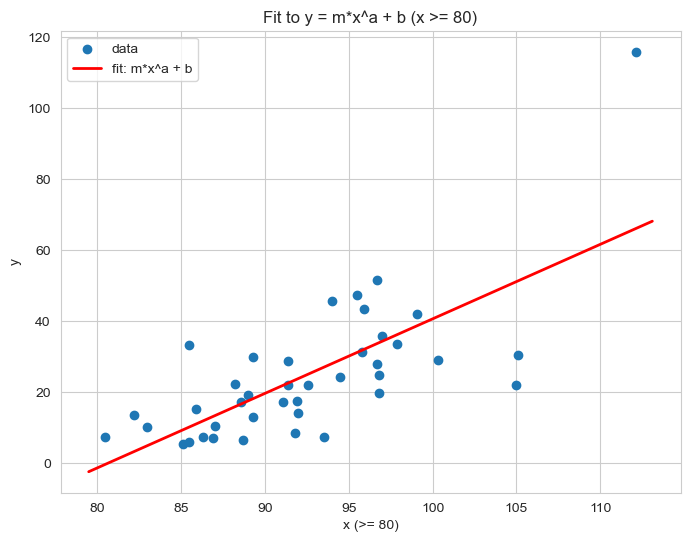

In [17]:
#This doens't seem like its outperforming a linear fit by much. Lets constrain a to 1, to make it linear 


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Replace these with your arrays (lists or 1D numpy arrays)
x_all = np.asarray(x_july_list, dtype=float)
y_all = np.asarray(y_list, dtype=float)

# Select x >= threshold and drop NaNs
x_thresh = 80.0
mask = (x_all >= x_thresh) & ~np.isnan(x_all) & ~np.isnan(y_all)
x = x_all[mask]
y = y_all[mask]

if len(x) == 0:
    raise ValueError("No data points with x >= {}".format(x_thresh))

# Model: y = m * x**a + b
def model(params, x):
    m, a, b = params
    return m * (x ** a) + b

def residuals(params, x, y):
    return model(params, x) - y

# initial guesses
m_init = max(1e-6, np.nanmean(y) / (np.nanmean(x) ** 1))
a_init = 1.0
b_init = np.median(y)  # reasonable starting offset
init = np.array([m_init, a_init, b_init], dtype=float)

# bounds: allow a up to 15
lower = [ 0,  0.99, -1e6]   # allow m negative if desired, a >= -5, b wide
upper = [  1e6,  1,  1e6]   # a upper bound 5

res = least_squares(residuals, init, args=(x, y), bounds=(lower, upper),
                    ftol=1e-9, xtol=1e-9, gtol=1e-9, max_nfev=50000)

m, a, b = res.x

# metrics
y_pred = model(res.x, x)
rss = np.sum((y - y_pred)**2)
rmse = np.sqrt(rss / len(y))
r2 = 1 - rss / np.sum((y - np.mean(y))**2)

print("success:", res.success, res.message)
print(f"m = {m:.6g}, a = {a:.6g}, b = {b:.6g}")
print(f"RMSE = {rmse:.4f}, R^2 = {r2:.4f}")

# plot
xs = np.linspace(x.min()-1, x.max()+1, 400)
plt.figure(figsize=(8,6))
plt.scatter(x, y, label='data', c='C0')
plt.plot(xs, m*xs**a + b, 'r-', lw=2, label='fit: m*x^a + b')
plt.xlabel('x (>= 80)')
plt.ylabel('y')
plt.legend()
plt.title('Fit to y = m*x^a + b (x >= 80)')
plt.show()

In [18]:
#The RMSE isn't much worse, so lets go with a linear fitting after 80 F 
#Also, lets force the minimum of B to be the lowest value we see at lower than 80 F 
min(y_list)

2.89

success: True `ftol` termination condition is satisfied.
m = 2.10187, a = 1, b = -169.555
RMSE = 13.5060, R^2 = 0.5052


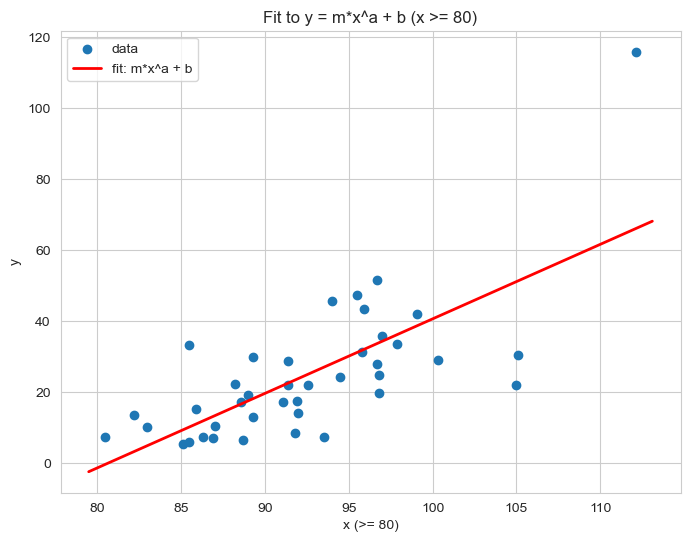

In [19]:
#This doens't seem like its outperforming a linear fit by much. Lets constrain a to 1, to make it linear 


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Replace these with your arrays (lists or 1D numpy arrays)
x_all = np.asarray(x_july_list, dtype=float)
y_all = np.asarray(y_list, dtype=float)

# Select x >= threshold and drop NaNs
x_thresh = 80.0
mask = (x_all >= x_thresh) & ~np.isnan(x_all) & ~np.isnan(y_all)
x = x_all[mask]
y = y_all[mask]

if len(x) == 0:
    raise ValueError("No data points with x >= {}".format(x_thresh))

# Model: y = m * x**a + b
def model(params, x):
    m, a, b = params
    return m * (x ** a) + b

def residuals(params, x, y):
    return model(params, x) - y

# initial guesses
m_init = max(1e-6, np.nanmean(y) / (np.nanmean(x) ** 1))
a_init = 1.0
b_init = np.median(y)  # reasonable starting offset
init = np.array([m_init, a_init, b_init], dtype=float)

# bounds: allow a up to 15
lower = [ 0,  0.99, -1e6]   # allow m negative if desired, a >= -5, b wide
upper = [  1e6,  1,  1e6]   # a upper bound 5

res = least_squares(residuals, init, args=(x, y), bounds=(lower, upper),
                    ftol=1e-9, xtol=1e-9, gtol=1e-9, max_nfev=50000)

m, a, b = res.x

# metrics
y_pred = model(res.x, x)
rss = np.sum((y - y_pred)**2)
rmse = np.sqrt(rss / len(y))
r2 = 1 - rss / np.sum((y - np.mean(y))**2)

print("success:", res.success, res.message)
print(f"m = {m:.6g}, a = {a:.6g}, b = {b:.6g}")
print(f"RMSE = {rmse:.4f}, R^2 = {r2:.4f}")

# plot
xs = np.linspace(x.min()-1, x.max()+1, 400)
plt.figure(figsize=(8,6))
plt.scatter(x, y, label='data', c='C0')
plt.plot(xs, m*xs**a + b, 'r-', lw=2, label='fit: m*x^a + b')
plt.xlabel('x (>= 80)')
plt.ylabel('y')
plt.legend()
plt.title('Fit to y = m*x^a + b (x >= 80)')
plt.show()

success: True `ftol` termination condition is satisfied.
m = 1.82998, a = 1, b (set so y(80)=y_min) = -143.509
RMSE = 13.6522, R^2 = 0.4945


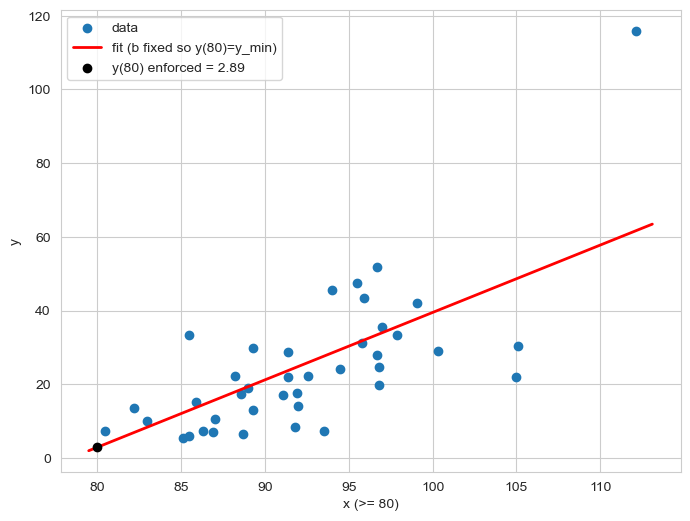

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# your arrays
x_all = np.asarray(x_july_list, dtype=float)
y_all = np.asarray(y_list, dtype=float)

# select x >= 80 and drop NaNs
x_thresh = 80.0
mask = (x_all >= x_thresh) & ~np.isnan(x_all) & ~np.isnan(y_all)
x = x_all[mask]
y = y_all[mask]

if len(x) == 0:
    raise ValueError("No data points with x >= {}".format(x_thresh))

# target value at x=80
y_min = np.nanmin(y_all)   # or np.min(y) if you only want min of chosen points
# if you explicitly want the min of the full original y_list (including x<80), keep np.nanmin(y_all)

# model: y = m * x**a + b, with b = y_min - m * (80**a)
def model_given_m_a(params, x):
    m, a = params
    b = y_min - m * (x_thresh ** a)
    return m * (x ** a) + b

def residuals(params, x, y):
    return model_given_m_a(params, x) - y

# initial guesses
m_init = max(1e-6, np.nanmean(y) / (np.nanmean(x)**1))
a_init = 1.0
init = np.array([m_init, a_init], dtype=float)

# bounds (allow a up to 15)
lower = [-1e6, 0.99]
upper = [ 1e6, 1]

res = least_squares(residuals, init, args=(x, y), bounds=(lower, upper),
                    ftol=1e-9, xtol=1e-9, gtol=1e-9, max_nfev=20000)

m_fit, a_fit = res.x
b_fit = y_min - m_fit * (x_thresh ** a_fit)

# diagnostics
y_pred = model_given_m_a(res.x, x)
rss = np.sum((y - y_pred)**2)
rmse = np.sqrt(rss / len(y))
r2 = 1 - rss / np.sum((y - np.mean(y))**2)

print("success:", res.success, res.message)
print(f"m = {m_fit:.6g}, a = {a_fit:.6g}, b (set so y(80)=y_min) = {b_fit:.6g}")
print(f"RMSE = {rmse:.4f}, R^2 = {r2:.4f}")

# plot
xs = np.linspace(x.min()-1, x.max()+1, 400)
ys = m_fit * xs**a_fit + b_fit
plt.figure(figsize=(8,6))
plt.scatter(x, y, label='data', c='C0')
plt.plot(xs, ys, 'r-', lw=2, label='fit (b fixed so y(80)=y_min)')
plt.scatter([x_thresh], [y_min], color='black', zorder=5, label=f'y(80) enforced = {y_min:.3g}')
plt.xlabel('x (>= 80)')
plt.ylabel('y')
plt.legend()
plt.show()

success: True `ftol` termination condition is satisfied.
m = 2.24588, a = 1, b (set so y(80)=y_min) = -176.78
RMSE = 14.2435, R^2 = 0.4497


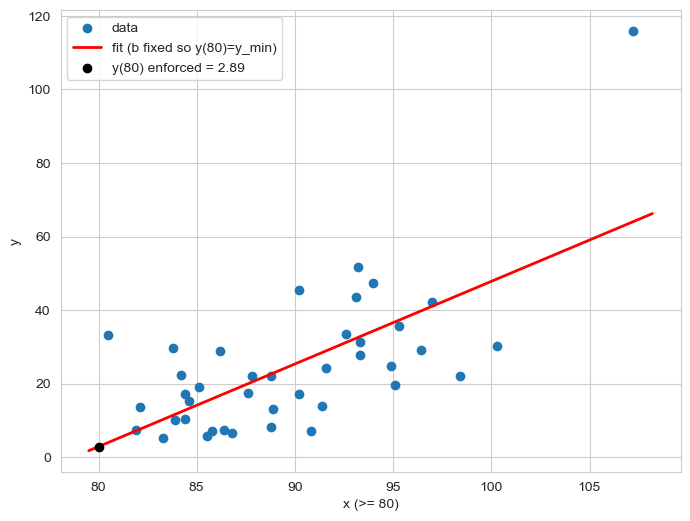

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# your arrays
x_all = np.asarray(x_august_list, dtype=float)
y_all = np.asarray(y_list, dtype=float)

# select x >= 80 and drop NaNs
x_thresh = 80.0
mask = (x_all >= x_thresh) & ~np.isnan(x_all) & ~np.isnan(y_all)
x = x_all[mask]
y = y_all[mask]

if len(x) == 0:
    raise ValueError("No data points with x >= {}".format(x_thresh))

# target value at x=80
y_min = np.nanmin(y_all)   # or np.min(y) if you only want min of chosen points
# if you explicitly want the min of the full original y_list (including x<80), keep np.nanmin(y_all)

# model: y = m * x**a + b, with b = y_min - m * (80**a)
def model_given_m_a(params, x):
    m, a = params
    b = y_min - m * (x_thresh ** a)
    return m * (x ** a) + b

def residuals(params, x, y):
    return model_given_m_a(params, x) - y

# initial guesses
m_init = max(1e-6, np.nanmean(y) / (np.nanmean(x)**1))
a_init = 1.0
init = np.array([m_init, a_init], dtype=float)

# bounds (allow a up to 15)
lower = [-1e6, 0.99]
upper = [ 1e6, 1]

res = least_squares(residuals, init, args=(x, y), bounds=(lower, upper),
                    ftol=1e-9, xtol=1e-9, gtol=1e-9, max_nfev=20000)

m_fit, a_fit = res.x
b_fit = y_min - m_fit * (x_thresh ** a_fit)

# diagnostics
y_pred = model_given_m_a(res.x, x)
rss = np.sum((y - y_pred)**2)
rmse = np.sqrt(rss / len(y))
r2 = 1 - rss / np.sum((y - np.mean(y))**2)

print("success:", res.success, res.message)
print(f"m = {m_fit:.6g}, a = {a_fit:.6g}, b (set so y(80)=y_min) = {b_fit:.6g}")
print(f"RMSE = {rmse:.4f}, R^2 = {r2:.4f}")

# plot
xs = np.linspace(x.min()-1, x.max()+1, 400)
ys = m_fit * xs**a_fit + b_fit
plt.figure(figsize=(8,6))
plt.scatter(x, y, label='data', c='C0')
plt.plot(xs, ys, 'r-', lw=2, label='fit (b fixed so y(80)=y_min)')
plt.scatter([x_thresh], [y_min], color='black', zorder=5, label=f'y(80) enforced = {y_min:.3g}')
plt.xlabel('x (>= 80)')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
#Ok, now I have an acceptable relationship between temperature and emergency visit. 
#August has a lower 
#Now I need to normalize this
#We can use this relationship, and subtract it, to get our residual plot 
#Time to redo EDA, but this time with residuals instead 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

sns.set_style("whitegrid")
county_df = pd.read_excel("data/County_Statistics.xlsx")
#dropping hospitalization
county_df = county_df.drop('Hospitalizations / 100000', axis=1)
county_df = county_df.drop('County', axis=1)
#drop na to drop rows with empty values for emergency visits
#our target is emergency visits for this analysis

county_df = county_df.dropna()
county_df.head()
#remove all instances of '%'
county_df['Park within 1/2 Mile'] = county_df['Park within 1/2 Mile'].str.removesuffix('%')
county_df['Imperviousness'] = county_df['Imperviousness'].str.removesuffix('%')
county_df['Energy Burden % of Income'] = county_df['Energy Burden % of Income'].str.removesuffix('%')
county_df['Housing Built before 1980'] = county_df['Housing Built before 1980'].str.removesuffix('%')
county_df['Housing Insecurity'] = county_df['Housing Insecurity'].str.removesuffix('%')
county_df['Lack of Reliable Transportation'] = county_df['Lack of Reliable Transportation'].str.removesuffix('%')
county_df['% w/o Internet'] = county_df['% w/o Internet'].str.removesuffix('%')
county_df['Utility Services Threat'] = county_df['Utility Services Threat'].str.removesuffix('%')

#convert to float
county_df['Park within 1/2 Mile'] = county_df['Park within 1/2 Mile'].astype(float)
county_df['Imperviousness'] = county_df['Imperviousness'].astype(float)
county_df['Energy Burden % of Income'] = county_df['Energy Burden % of Income'].astype(float)
county_df['Hospital Beds / 10000'] = county_df['Hospital Beds / 10000'].astype(float)
county_df['Housing Built before 1980'] = county_df['Housing Built before 1980'].astype(float)
county_df['Housing Insecurity'] = county_df['Housing Insecurity'].astype(float)
county_df['Lack of Reliable Transportation'] = county_df['Lack of Reliable Transportation'].astype(float)
county_df['% w/o Internet'] = county_df['% w/o Internet'].astype(float)
county_df['Utility Services Threat'] = county_df['Utility Services Threat'].astype(float)


county_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 2 to 56
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Emergency Visits / 100000        42 non-null     float64
 1   Energy Burden % of Income        42 non-null     float64
 2   Imperviousness                   42 non-null     float64
 3   Park within 1/2 Mile             42 non-null     float64
 4   Hospital Beds / 10000            42 non-null     float64
 5   Housing Built before 1980        42 non-null     float64
 6   Housing Insecurity               42 non-null     float64
 7   Lack of Reliable Transportation  42 non-null     float64
 8   % w/o Internet                   42 non-null     float64
 9   Utility Services Threat          42 non-null     float64
dtypes: float64(10)
memory usage: 3.6 KB


In [23]:
county_df.sample()

,Emergency Visits / 100000,Energy Burden % of Income,Imperviousness,Park within 1/2 Mile,Hospital Beds / 10000,Housing Built before 1980,Housing Insecurity,Lack of Reliable Transportation,% w/o Internet,Utility Services Threat
36,2.89,0.8,62.3,100.0,32.87,79.4,9.1,6.8,6.0,4.6


In [24]:
import numpy as np
import pandas as pd

# inputs: your DataFrame and the fitted params
county_df = county_df.copy()   # avoid modifying original in-place unless you want to
temp_col = "July max temp (F)"    # <- change this to the actual temp column name in your df
y_col = "Emergency Visits / 100000"
resid_col = y_col + " residual"

# fitted parameters (from your fit)
m = 1.82998
a = 1.0
b = -143.509   # already set so that y(80) = y_min

# compute y_hat (temperature effect) and residuals
# safe handling of missing values: result will be NaN if either temp or y is NaN
temp = county_df[temp_col].astype(float)    # ensure numeric
y_obs = county_df[y_col].astype(float)

y_hat = m * (temp ** a) + b
y_resid = y_obs - y_hat

# assign new column
county_df[resid_col] = y_resid

# (optional) also store the fitted component for inspection
county_df[y_col + " (temp_effect)"] = y_hat

# Show a quick check
print(county_df[[temp_col, y_col, y_col + " (temp_effect)", resid_col]].head())

# If you want to overwrite original df rather than a copy, remove the .copy() above

KeyError: 'July max temp (F)'